## Importing Necessary Modules

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Read csv file

In [2]:
# Read in the CSV file as a Pandas DataFrame
skin_metadata_df = pd.read_csv(
    Path("../Resources/cleaned_encoded_skin_metadata.csv")
)

# Review the DataFrame
skin_metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,result,result_label
0,118,3113,2,3,80.0,1,11,2,0,Benign
1,118,724,2,3,80.0,1,11,2,0,Benign
2,2710,2463,2,3,80.0,1,11,2,0,Benign
3,2710,1355,2,3,80.0,1,11,2,0,Benign
4,1460,7327,2,3,75.0,1,4,2,0,Benign


In [3]:
skin_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  int64  
 1   image_id      10015 non-null  int64  
 2   dx            10015 non-null  int64  
 3   dx_type       10015 non-null  int64  
 4   age           10015 non-null  float64
 5   sex           10015 non-null  int64  
 6   localization  10015 non-null  int64  
 7   diagnosis     10015 non-null  int64  
 8   result        10015 non-null  int64  
 9   result_label  10015 non-null  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 782.6+ KB


In [4]:
skin_metadata_df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
diagnosis       0
result          0
result_label    0
dtype: int64

In [5]:
skin_metadata_df['diagnosis'].value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: diagnosis, dtype: int64

In [6]:
# Define features set
X = skin_metadata_df.copy()
X.drop(["lesion_id","image_id","dx","diagnosis", "result", "result_label"], axis=1, inplace=True)
X.head()

,dx_type,age,sex,localization
0,3,80.0,1,11
1,3,80.0,1,11
2,3,80.0,1,11
3,3,80.0,1,11
4,3,75.0,1,4


In [7]:
# Define target vector
y = skin_metadata_df["result"].ravel()
y[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [8]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

## Normalisation

In [9]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [10]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [11]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

In [13]:
rus = RandomUnderSampler(random_state=1)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

In [14]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [15]:
# Fitting the model
rf_model = rf_model.fit(X_train_resampled, y_train_resampled)

## Making Predictions Using the Random Forest Model

In [16]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation

In [17]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Creating a DataFrame from the confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Benign", "Cancer"], columns=["Predicted Benign", "Predicted Cancer"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [18]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted Benign,Predicted Cancer
Benign,1136,456
Cancer,32,379


Accuracy Score : 0.7563654518222666
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1592
           1       0.45      0.92      0.61       411

    accuracy                           0.76      2003
   macro avg       0.71      0.82      0.72      2003
weighted avg       0.87      0.76      0.78      2003



## Feature Importance

In [19]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5306550515957107, 'dx_type'),
 (0.28970480917823244, 'age'),
 (0.15226383316735886, 'localization'),
 (0.027376306058697997, 'sex')]

In [20]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5306550515957107, 'dx_type'),
 (0.28970480917823244, 'age'),
 (0.15226383316735886, 'localization'),
 (0.027376306058697997, 'sex')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

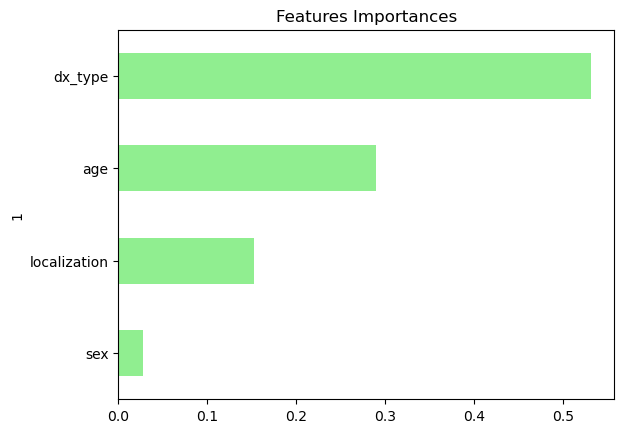

In [21]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)